# Assignment 2 - Plant Classification

Project Name: COSC102 - Plant Classification <br>
Author: - <br>
Email: - <br>
Date: - <br>


For this project we will be looking at a dataset of plant descriptive variables that were collected at four different locations <br>
in the United states. Our task is to train a Classification Machine learning Algorithm that is able to identify which of the four <br>
locations a plant was found by using only two features from the dataset collect. We will obviously be trying to first find which <br>
two variables return the best results to use, then finding the classification algorithm that best fits the data in our dataset <br>
before finally running performance tests on our solution and coming to conclusions on our decisions and choices made throughtout <br>
the project. Without further ado... shall we!

In [434]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, auc


## Load the dataset and partition the dataset in the train and test sets

In [437]:
# Create a function to load in csv files.

def load_dataset(csv_file_path):
    """ Takes a string of a csv's file path and converts it to a pandas dataframe.
    param: String - CSV file path.
    return Dataframe - A pandas dataframe.
    """
    return pd.read_csv(csv_file_path)

In [439]:
# Define the file path for our data and call the load_dataset function to create our pandas object
csv_file_path = "./Plants_Dataset.csv"
plants = load_dataset(csv_file_path)

In [884]:
# Print some basic information about our dataset
plants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Site        80 non-null     object 
 1   height      80 non-null     int64  
 2   mouth_diam  80 non-null     float64
 3   tube_diam   80 non-null     float64
 4   keel_diam   80 non-null     float64
 5   wingspread  80 non-null     int64  
 6   hoodarea    80 non-null     float64
 7   wingarea    80 non-null     float64
 8   tubearea    80 non-null     float64
 9   tubemass_g  80 non-null     float64
 10  wingmass_g  80 non-null     float64
 11  Ca_ppm      80 non-null     float64
 12  P_ppm       80 non-null     float64
 13  K_ppm       80 non-null     float64
 14  Mg_ppm      80 non-null     float64
 15  C_pct       80 non-null     float64
 16  H_pct       80 non-null     float64
 17  N_pct       80 non-null     float64
dtypes: float64(15), int64(2), object(1)
memory usage: 11.4+ KB


Our datas mostly numerical types except for "Site" which is type object, which will be a string in the abbreviated form of where the specimen was found. <br>
An important point to take note of is there is no missing values in our dataset, therefore we won't have to replace any values. Since this assignment <br>
call for us to choose the best two performing features from the dataset and use them to plot out our results, we don't have to think too much about how <br>
to frame our data or different combinations or statistics we could use to show patterns. We just have to solve the problem that is asked, which is very <br>
straight forward and will therefore cut out alot of the thinking. So without wasting anymore precious characters..... lets split up our data and go from there.


In [444]:
# EXPLANATION 1 MAYBE USE FOR REPORT
# We split the data into two sets, one for training and one for testing. We also have to separate out our labels
# since our goal is to train an algorithm that is able to distinguish the site at which a plant is found from two
# of it's characteristics, it's obvious that our x set needs to contain all the different types of data we could
# train our model with and the y set contain just the labels. Since the site is our labels, we drop the site values
# out of our x set and create a y set solely containing the sites. Since our dataset contains 80 plants in total
# and the default split size is 25% I won't change this value as that makes a perfect 60/20 split. The universe calls
# for me to set the random state to 42.... also because we can control the randomness this way.

# EXPLANATION 2 PROBABLY KEEP FOR JUYPTER FILE.
# Split our data into the train and test sets. Since we are training an algorithm to learn which site locations our plants are found 
# we will obviously split our x data points as all the data and our y data points as our labels which only contains the site abbriviations

X_train, X_test, y_train, y_test = train_test_split(plants.drop("Site", axis=1), plants.Site, random_state=42)

# Convert the pandas dataseries to a numpy array for processing
X_train = X_train.values
X_test = X_test.values

## Select the 2 most higher-performing features based upon cross-validation carried out on the training dataset.

In [944]:
# Creating a method to sort all of our features and pick the best ones to use

# TODO - change this so that I can input any type of classifier in and it will run the project on that classifier

def feature_selection( X_value, y_value, f1, f2):
    """
    Takes in an x, y pair of pandas dataset and two integers. It uses the integers as indexes for the X set of data
    to slice and only use the features represented by those indexes. It does this by training a classifier on the
    sliced data and the y values, then claculates the f1 score and returns the model, and the f1 score.
    params: 
    X_value - a pandas dataset of the x values
    y_value - a pandas dataset of the y values
    f1 - an integer to be used for slicing
    f2 - an integer to be used for slicing
    return
    """

    # Create and train our classifier
    clf = SVC()
    # clf = SGDClassifier(random_state=42)
    clf = KNeighborsClassifier()
    clf.fit(X_train[:, [f1,f2]], y_train)

    # Calculate our model values
    y_train_pred = cross_val_predict(clf, X_value[:, [f1,f2]], y_value, cv=5)
    # confusion_matrix(y_train, y_train_pred)

    # Using macro as we should have an even amount of sites in our dataset
    # p = precision_score(y_train, y_train_pred, average="macro",zero_division=1)
    # r = recall_score(y_train, y_train_pred, average="macro")
    f = f1_score(y_train, y_train_pred, average="macro")
    # print(f"features {f1, f2} have a precision {p} recall {r} and f1 score of {f}") #, round(r[0],4), round(f[0],4)
    return f, clf
    
    # print(type(f1))    

In [946]:
# Create a function to scale our data.

# TEST if this cell is even needed

def scale_data(dataset):
    """
    Takes in a array and uses the sklearns built in scaler function to scale the data in the array
    param:
    Dataset - an array
    """
    scaler = StandardScaler()
    scaler.fit(dataset)

# Standardizing our X set, we will do this to our test set later, we also don't need to do this to our y set since it is just labels.
scale_data(X_train)

In [948]:
# svm = SVC()
# svm.fit(X_train, y_train)
# svm.predict(X_test)

# y_pred = cross_val_predict(svm, X_train, y_train, cv=3)
# y_test_pred = svm.predict(X_test)

# conf = confusion_matrix(y_train, y_pred)
# conf_test = confusion_matrix(y_test, y_test_pred)

In [951]:
# Set the variables we will need to distinguish which features are the best for modeling 
best_f1 = 0
best_f2 = 0
best_score = 0



# A nested for loop to interate through all combinations of feautures in our data set to send to a function which will determine the most
# accurate combination of two to use in our model
for feature_1 in range(17):
    for feature_2 in range(17):
        if feature_1 == feature_2:
            continue
        returned_score, clf = feature_selection( X_train, y_train, feature_1, feature_2)
        
        if float(returned_score) > best_score:
            
            best_score = returned_score
            best_f1 = feature_1
            best_f2 = feature_2
            classifier_of_choice = clf
            print(best_f1, best_f2) 
# TODO triple nest the for loop and make the first loop, loop through different classifiers.


0 1
0 4
0 7
0 10
0 12
1 2
1 3
1 5
8 15
9 16
15 16


## Construct a confusion matrix based on the classifers performance on the test set and use this to calculate the recall, precision and F1 scores for each class.

In [954]:
scale_data(X_test)

In [956]:
# turn this into a function so that I can just call it and input a type of classifier and it outputs the classifiers name and results

y_test_processed = classifier_of_choice.predict(X_test[:,[best_f1, best_f2]])
c = confusion_matrix(y_test, y_test_processed)

print(f"Test set Precision: {precision_score(y_test, y_test_processed, average='macro', zero_division=False)}")
print(f"Test set Recall: {recall_score(y_test, y_test_processed, average='macro')}")
print(f"Test set F1: {f1_score(y_test, y_test_processed, average='macro')}")

Test set Precision: 0.9
Test set Recall: 0.875
Test set F1: 0.8541666666666666


## Construct a ROC curve for each class and calculate the respective AUC values

In [1009]:
# Write code here that detects which classifier im using so that a knn works as well as an sgd

# if clf_choice == "knn":
y_scores = classifier_of_choice.predict_proba(X_train[:, [best_f1,best_f2]])

# y_scores = cross_val_predict(classifier_of_choice, X_train, y_train, cv=5, method="decision_function")

# y_scores = cross_val_predict(classifier_of_choice, X_test, y_test, cv=3, method="decision_function")


In [1057]:
# This is a mystery... as in when the classes are in this order... godlike, otherwise, trash... i need to know why this is
y_train_bin = label_binarize(y_train, classes=["DG", "HD", "LEH", "TJH"])

# Use this to confirm we got our classes lined up correctly with our label binarizer
y = pd.DataFrame(y_train_bin, index=y_train.index, columns=["DG", "HD", "LEH", "TJH"])
print(y.head(10))
print(y_train.head(10))

# That's good enough for me


    DG  HD  LEH  TJH
9    0   0    0    1
64   0   0    1    0
5    0   0    0    1
47   1   0    0    0
34   1   0    0    0
62   0   0    1    0
42   1   0    0    0
54   0   0    1    0
16   0   0    0    1
39   1   0    0    0
9     TJH
64    LEH
5     TJH
47     DG
34     DG
62    LEH
42     DG
54    LEH
16    TJH
39     DG
Name: Site, dtype: object


'DG'

Class DG Area Under Curve score: 0.8597811217510261
Class HD Area Under Curve score: 0.9673202614379085
Class LEH Area Under Curve score: 0.9511111111111112
Class TJH Area Under Curve score: 0.9326059050064185


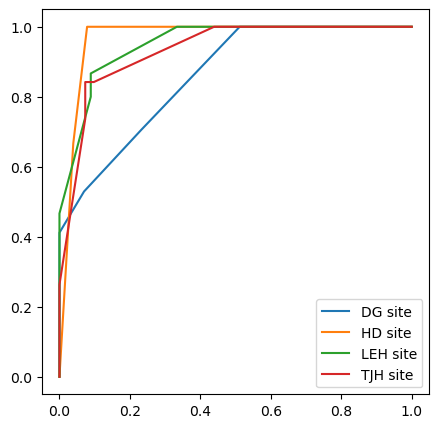

In [1071]:
fig, ax = plt.subplots(figsize=(5,5))
# colors = ["r", "b", "g", "c"]

for i in range(4):
    fpr, tpr, thresholds = roc_curve(y_train_bin[:, i], y_scores[:, i])
    print(f"Class {y.columns[i]} Area Under Curve score: {roc_auc_score(y_train_bin[:, i], y_scores[:, i])}")
    plt.plot(fpr, tpr, label=y.columns[i] + " site")

plt.legend()

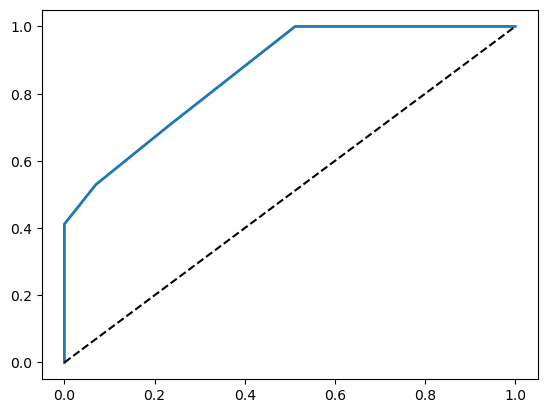

In [1029]:
# Deffs customize this 



def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal [...] # Add axis labels and grid
    
plot_roc_curve(fpr, tpr)
plt.show()


## Construct a suitable visualisation that demonstrates the decision boundaries learned by the classifer on the features selected through the cross validation process (test data aswell)

27/07/24
For two days i've been trying to figure out this project, how to approach it, how to achieve a correct result.... for two days I have wasted my time. Well... wasted is abit strong, every second i spend trying something new i'm learning... be it correct or a mistake, everything is contributing at the moment. I feel very inadequate with datascience at the moment, though after reading through chapters 2 and 3, six or seven times, it's starting to make more sense in my mind. For the last few days I have been trying to create a binary classifier for a dataset that I need to make a multiclassifier for... now this isn't exactly a problem if I knew that, but I didn't so a few things really made no sense. I think i'm starting to come around to being able to fully complete this assignment now.

28/07/24
So I thought I had figured something out but no... i'm just an idiot. I thought I had to implement a multiclassifier, even though that makes sense to me, the criteria for the assignment doesn't want that... I have to select two features and get the precision, recall, blah blah blah... you don't do that with a multiclassifier, well atleast in my solution I didn't. I did successfully build one for this project.... very quickly too, but it's no good for the assignment, so now i'm back to square one, being very confused about what I have to do. It's not that I don't know what to do or even how to do it, it's the lack of clarity and understanding in all of this, alot seems to be taken for granted in this course at the moment, feel like im teaching myself in all honesty.

29/07/24
Ok here we go, so i'm coming in fresh with the mind frame of building this in such a way that it could be universal (or close enough) for any dataset you would wanna do this to. I know how to do it (I think), but it's more about implementation.

So mid session update and i'm pretty sure im doing it wrong again and I already had it right from days ago.... multiclassifier, just run precision and recall on it after it's trained, run the test data, plot it out and you are done... I think I finished this assignment already but threw it all out thinking I didn't understand.... man I don't understand anything.

30/07/24
Now we are focusing on finding the two best features, I think I have a solution, though my f1 scores are really low... not sure if that's a me problem, a model selection problem or it is what it is. 

Ok now im confused, I can't iterate through an SVM to find the feature two features?

My mistake, it was but a coding error... I was returning a tuple for my two f1 scores from a function, but i was unable to unpack the variables... this is because i went for dinner and came back and forgot to write that part of the code.... harmless mistake.... harmless shuts down all microsoft computers mistake... just push on commit.

Success tonight, after 12 hours in this assignment I finally feel like im on the right track, 3 of the 5 parts down and I should be able to finish the rest of it much faster then this has taken already. I feel after 5 weeks of this class, that im finally coming around to how I need to think to be able to run these note books... what do i mean by that? well, not that im able to do anything in datascience yet, but just that, like normal program, whenever im given a problem, I find it very easy to code a solution, be it some app or even a fullstack backend, frontend, database solution. But  with datascience, ive been struggling to remember that it's just python, and it's just programming, you're just thinking about what you are trying to achieve a little bit differently... anyway i'm rambling. Good session.

31/07/24
Ok starting today off great, realized I trained the data on a single classifier that had all the data and not trained on two of each feature at a time, meaning that my solution is.... not correct... I will now attempt to fix this...

Ok, two minutes later, I think I fixed it, but i gotta be honest.... I feel less and less confident about this project with every passing cell i press shift+enter on.... I don't know if ive done things right and I think this is going to lead to me running multiple classifiers to compare results and see just how wrong or right I am...

30 more minutes...... i've done it! and i've written a function so that I can just pass in whatever classifier I want and everything is fit, trained, tested, calculated... you name it. Still have the roc curves and plots to make, but that shouldn't be hard at all (famous last words) 

Literal famous last words, running into some high headwind at the moment, may have banged my head against the wall enough for one day already (struggling with calculus as it is). Made good progress though, I have a way to run any classifier I want on the dataset, I just need to do a bit of cleaning up and tweaking to allow any classifier without any changing of code or errors. As for roc curves... well, apparently they dont allow for multiclasses, or so it complains at me, though I know that is wrong as I know you can do it, I just gotta figure out how too... for tomorrow, roc curves, pretty plots, then big clean up, document, blah blah blah.

1/08/24
Ok day 6ish.. 7ish.. here we go, roc curves and maybe some plotting.

Rough start with the multi-class roc curve problem... figure my problem out, when binarizing the labels I had to declare the names of the labels and not just assign number values to each label... now we getting somewhere.

Too confident, something is wrong with everything but i cant quite figure out what it is. The knn model smashes the other two out of the water in terms of its scores, and so its auc should be higher... by alot, but it isnt, infact it's roc curves are worse and it looks like its only picking up on like 5 pieces of data..... Im unsure, gonna have to hit the google, the textbox, the tutorial and the lecture to see what I could have possibly got wrong.

mm, realizing some mistakes.... some holes... this ship is sinking... shower and refresh, approach it once more tonight from a place of cleaning and simplifing... pick up the pieces tomorrow and go again. simple.

Wow, amazing what a shower can do... I was ordering my labels incorrectly which was throwing everything majorly out of whack... came back, realized this, found a way to order them correctly and bim bop boom... roc curves all over 90 matching the other metrics and plotting correctly.... we leave it here for now. 21 hours in and still no finished product... haha and im not even optimizing as I go... oh but we will optimize... oh yes we... will.